# Chromatin Ensemble Refinement 
## 1. Objective 
* Infer the ensemble of chromatin structures $X = {x_m}$ and their weights $\alpha_m$ with $m \in {1, ..., M}$.
  * $M$ is the toal number of structures. This is a predefined hyperparameter. This variable affects the accuracy and the stability of the ensemble refinement.
* Infer $X$ from a set of single-cell distance matrix $D_n$ with $n \in {1, ..., N}$.
  * \mathcal{D} = {D_n} is the full sety of single-cell observations.

## 2. Forward Model 
* Each structure $x_m = \{\vec{r_i}\}_{i=1}^{N_{\text{probes}}}$.
  * $\vec{r_i}$ is a row vector with 3 columns represent a 3D position of probe $i$. 
* Assume that each chromatin is a polymer chain and a Gaussian noise for the measurements. 
  * If the distance matrix is complete, then there is a one-to-one correspondence between 3D structure and the distance matrix $$x \longleftrightarrow D$$
where $D_{ij} = \lVert \vec{r_i} - \vec{r_j} \rVert _2$
  

## 3. Posterior
* We will build on the methods developed for single-particle cryo-EM to develop the chromatin ensemble refinement pipeline.
* Posterior can be written as $$ p(\alpha, X| \mathcal{D}) \propto \prod_{n=1}^N \left[\sum_{m=1}^M \alpha_m \, p(D_n|x_m) \, p(\alpha_m) \, p(x_m) \right]$$

where $X = {x_m}$ is the ensemble of $M$ chromatin structures. 

* Here we assume that all single-cell measurements, the priors over weights $p(\alpha)* and structures $p(x_m)$ are independent.
* Under the Gaussian noise model, we assume that all distance observations are i.i.d, so we can write $$p(D_n|x_m) = \prod_{i=1}^{N_{\text{probes}}}\prod_{j=1}^{N_{\text{probes}}}\frac{1}{\sqrt{2\pi}\sigma}\exp{\frac{(D_n^{ij}-D_m^{ij})^2}{2\sigma^2}} = \frac{1}{(\sqrt{2\pi}\sigma)^{N^2_{\text{probes}}}}\exp{\frac{-\lVert D_n - D_m \rVert _2^2}{2\sigma^2}}$$

In [38]:
import jax 
import scipy
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp1d, CubicSpline

In [4]:
# define some helper functions 

def generate_gaussian_chain(num_monomers: int, 
                            mean_bond_length: float, 
                            std_bond_length: float):
    """Generate a Gaussian chain polymer 
    
    Parameters
    ----------
    num_monomers
    mean_bond_length
    std_bond_length
    
    Return
    ------
    np.array 
    
    Notes
    -----
    """ 
    # Generate steps: each step is a 3D vector 
    steps = np.random.normal(mean_bond_length, std_bond_length, size=(num_monomers, 3))
    
    # Compute positions by cumulative sum of steps
    positions = np.cumsum(steps, axis=0)
    
    return positions

In [52]:
def visualize_polymer(polymer_chain):
    """Plot a polymer chain in 3D space
    
    Parameters
    ----------
    polymer_chain
    
    Return
    ------
    
    """
    # Extract each coordinate of this polymer chain 
    x = polymer_chain[:, 0]
    y = polymer_chain[:, 1]
    z = polymer_chain[:, 2]
    
    # Intepolate path between monomer to show connectivity within the polymer
    # Parameterize by cumulative distance along the points
    t = np.zeros(x.shape)
    t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2 + (z[1:] - z[:-1])**2)
    t = np.cumsum(t)
    
    # Create a cubic spline interpolation for each dimension
    cs_x = CubicSpline(t, x)
    cs_y = CubicSpline(t, y)
    cs_z = CubicSpline(t, z)
    
    # Normalize the monomer number 
    num_monomers = polymer_chain.shape[0] 
    norm_monomer_number = np.arange(0, num_monomers) / num_monomers
    monomer_colors = cm.rainbow(norm_monomer_number)

    # Generate fine samples for a smooth curve
    t_fine = np.linspace(t[0], t[-1], 500)
    x_fine = cs_x(t_fine)
    y_fine = cs_y(t_fine)
    z_fine = cs_z(t_fine)

    # Create a new matplotlib figure and an axes instance (the 3d part)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot using scatter
    ax.plot(x_fine, y_fine, z_fine, 'gray', label='Interpolated Path')
    for i in range(num_monomers):
        ax.scatter(x[i], y[i], z[i], color=monomer_colors[i], s=50, alpha=0.75) 

    # Labeling the axes (optional but recommended for clarity)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    # Create a ScalarMappable with the same colormap and normalization as the scatter
    # sm = cm.ScalarMappable(cmap='rainbow', norm=norm_monomer_number)
    # sm.set_array([]) 
    
    # Add colorbar
    # cbar = plt.colorbar(sm, ax=ax)
    # cbar.set_label('Monomer number')
    
    ax.legend()
    plt.show()


In [93]:
# Example of a gaussian chain 
# with 1000 monomers, mean bond length = 10, and std bond length = 1
num_monomers = 100
mean_bond_length = 1 
std_bond_length = 10

chain = generate_gaussian_chain(num_monomers, mean_bond_length, std_bond_length)

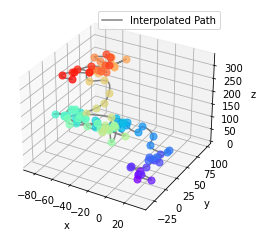

In [94]:
visualize_polymer(chain)

In [95]:
def calculate_gaussian_chain_conformation_prob(gaussian_polymer_chain):
    """Calculate the probability of a particular gaussian chain
    
    Parameters
    ----------
    gaussian_polymer_chain
    
    Return
    ------
    
    
    Notes
    -----
    """
    # Calculate square end-to-end distance of this gaussian chain
    end_to_end_distance_sq = np.sum((gaussian_polymer_chain[0, :] - gaussian_polymer_chain[-1, :])**2)
    
    # Calculate Kuhn length or average bond length of this gaussian chain
    mean_bond_length = np.mean(np.sum(np.diff(gaussian_polymer_chain, n=1, axis=0)**2, 1))
    
    # Calculate the number of monomers in this polymer chain
    num_monomers = gaussian_polymer_chain.shape[0]
    
    # Calculate probability according to the theory note 
    prob = ((3/(2*np.pi*num_monomers*mean_bond_length**2)) ** 1.5) * np.exp(-3*end_to_end_distance_sq/(2*num_monomers*mean_bond_length**2))
    
    return prob    
    
    

In [96]:
calculate_gaussian_chain_conformation_prob(chain)

1.121288114469846e-11